In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import gc
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


## Loading and reading the dataset

In [2]:
df = pd.read_csv("train.csv")
print("Train shape : ",df.shape)


Train shape :  (1306122, 3)


In [3]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


## **EDA**

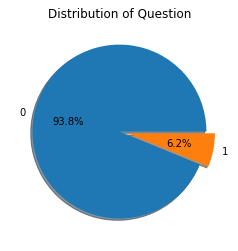

In [4]:
ax=df['target'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Question')
ax.set_ylabel('')
plt.show()

In [0]:
X = df["question_text"].values
y = df['target'].values

### Making word cloud

In [0]:
insincere_questions = df.loc[df['target'] == 1].values

In [7]:
len(insincere_questions)

80810

In [8]:
insincere_questions[0][1]

'Has the United States become the largest dictatorship in the world?'

In [9]:
from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
word_tokens = [word_tokenize(question[1]) for question in insincere_questions]

#freq_dist = FreqDist([word for question in insincere_questions for word in question[1].split()])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
word_tokens[1][1]

'babies'

In [0]:
all_words = [word for question in word_tokens for word in question]

In [12]:
len(all_words)

1582702

In [0]:
without_stopwords = [w for w in all_words if not w in stop_words]

In [14]:
len(without_stopwords)

1017310

In [0]:
words_len = [w for w in without_stopwords if not len(w)<5]

In [16]:
len(words_len)

536765

In [0]:
freq_dist = FreqDist([word for word in words_len])

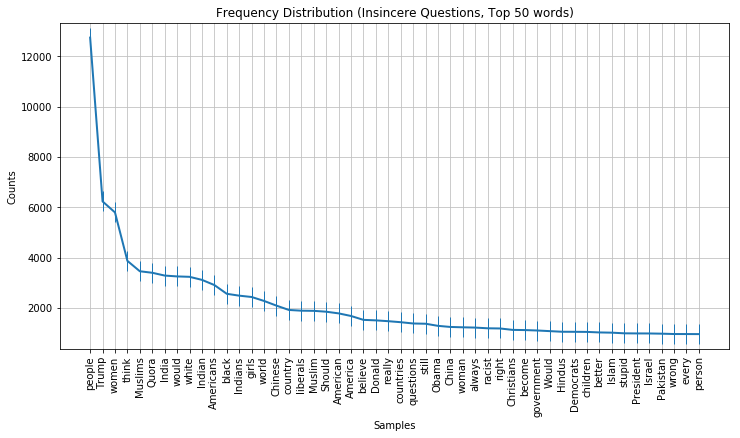

In [18]:
plt.figure(figsize=(12,6))
plt.title(f'Frequency Distribution (Insincere Questions, Top 50 words)')
freq_dist.plot(50, marker='|', markersize=20)
plt.show()

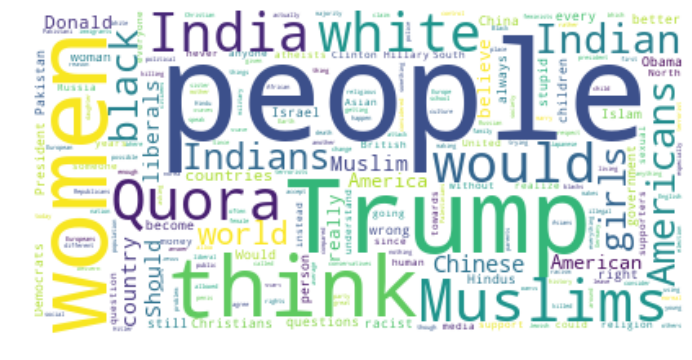

In [19]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='White').generate_from_frequencies(freq_dist)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Splitting dataset into train and test

In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)

In [21]:
train_X[110]

'What would be a safe score or rank for clearing the JNU entrance exam for M. Sc biotechnology life sciences and molecular medicine?'

In [22]:
print("Train shape : ",train_X.shape)
print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)


Train shape :  (881631,)
Validation shape :  (97960,)
Test shape :  (326531,)


In [23]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 827085]
 [     1  54546]]
[[    0 91899]
 [    1  6061]]
[[     0 306328]
 [     1  20203]]


In [24]:
testdf = pd.DataFrame()
testdf['question'] = test_X

testdf['target'] = test_y
testdf.shape

(326531, 2)

## Tokenize the sentences

In [0]:
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use


In [0]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 


In [0]:
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

In [28]:
len(train_X)

881631

In [29]:
train_X[110]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          2,   35,   25,    4,  445,  369,   23,  342,   13, 3818,    1,
       5646, 1279,  254,   13,  613, 1280, 3105,   74, 3016,   10, 4062,
       1223], dtype=int32)

## **Undersampling**

In [30]:
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(train_X, train_y)
print(sorted(Counter(y_resampled).items()))

[(0, 54546), (1, 54546)]


In [31]:
train_X.shape

(881631, 100)

In [32]:
train_X[110]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          2,   35,   25,    4,  445,  369,   23,  342,   13, 3818,    1,
       5646, 1279,  254,   13,  613, 1280, 3105,   74, 3016,   10, 4062,
       1223], dtype=int32)

In [0]:
embed_size = 100 # how big is each word vector

S_DROPOUT = 0.4
DROPOUT = 0.1

In [0]:
def plotting(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [35]:
train_X.shape

(881631, 100)

In [36]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[     0 827085]
 [     1  54546]]
[[    0 91899]
 [    1  6061]]
[[     0 306328]
 [     1  20203]]


## Glove Embeddings

In [0]:
from numpy import asarray
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [0]:
from numpy import zeros
# create a weight matrix for words in training docs
embedding_matrix = zeros((max_features, 100))
for word, i in tokenizer.word_index.items():
  if i >= max_features: continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

## **Utility Functions**

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score

In [0]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive 
  TN = cm.iloc[0,0] # True Negative 
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

In [0]:
def getROCMetrics(y_test, y_prob_rain):
  fpr, tpr, thresholds = roc_curve(y_test,y_prob_rain[:,1])

  #ROC Curve
  fig,ax1 = plt.subplots(figsize=(9,6))
  ax1.plot(fpr, tpr,color='orange')
  ax1.legend(['ROC Curve'],loc=1)
  ax1.set_xlim([-0.005, 1.0])
  ax1.set_ylim([0,1])
  ax1.set_ylabel('True Positive Rate (Sensitivity)')
  ax1.set_xlabel('False Positive Rate \n(1 - Specificity)\n FP / (TN + FP)')
  ax1.set_title('ROC Curve for RainTomorrow\n')

#   plt.plot([0,1],[0,1],linestyle='--',color='teal')
#   plt.plot([0,1],[0.5,0.5],linestyle='--',color='red',linewidth=0.25)

#   #Threshold Curve
#   ax2 = plt.gca().twinx()
#   ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='black')
#   ax2.legend(['Threshold'],loc=4)
#   ax2.set_ylabel('Threshold',color='black')
#   ax2.set_ylim([0,1])
#   ax2.grid(False)
  
  plt.show()
  
  rf_auc = roc_auc_score(y_test,y_prob_rain[:,1])
  print('AUC Score:', rf_auc*100)
  return rf_auc*100

#Models

## Without pretrained embeddings

In [42]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)



x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)  

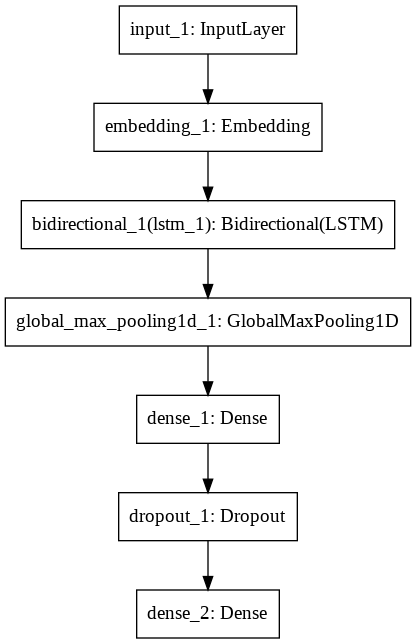

In [43]:
from keras.utils import  plot_model
from IPython.display import Image, display
model_name = 'Without pretrained embeddings'
plot_model(model, to_file = model_name +'-model.png', show_shapes=False)
Image(filename = model_name + '-model.png')

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 109092 samples, validate on 97960 samples
Epoch 1/5
109092/109092 [==============================] - 95s 874us/step - loss: 0.4019 - acc: 0.8346 - val_loss: 0.2787 - val_acc: 0.8862
Epoch 2/5
109092/109092 [==============================] - 94s 863us/step - loss: 0.2539 - acc: 0.9056 - val_loss: 0.2314 - val_acc: 0.9051
Epoch 3/5
109092/109092 [==============================] - 93s 851us/step - loss: 0.2185 - acc: 0.9215 - val_loss: 0.2978 - val_acc: 0.8758
Epoch 4/5
109092/109092 [==============================] - 92s 844us/step - loss: 0.1920 - acc: 0.9320 - val_loss: 0.3053 - val_acc: 0.8773
Epoch 5/5
109092/109092 [==============================] - 92s 843us/step - loss: 0.1656 - acc: 0.9429 - val_loss: 0.3252 - val_acc: 0.8756


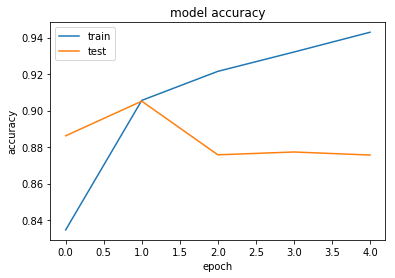

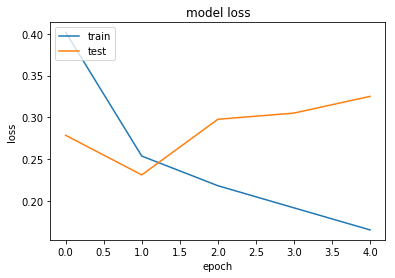

Test Accuracy: 87.790133


In [44]:
## Train the model 
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=5, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [45]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)

97960/97960 [==============================] - 13s 135us/step


In [46]:

thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

F1 score at threshold 0.1 is 0.3414342510387708
F1 score at threshold 0.11 is 0.34744703551287914
F1 score at threshold 0.12 is 0.3535155642628355
F1 score at threshold 0.13 is 0.3581806696146557
F1 score at threshold 0.14 is 0.36327473373540353
F1 score at threshold 0.15 is 0.3680917622523462
F1 score at threshold 0.16 is 0.37247391361775195
F1 score at threshold 0.17 is 0.3766594215014212
F1 score at threshold 0.18 is 0.3806169787680742
F1 score at threshold 0.19 is 0.38454682572329635
F1 score at threshold 0.2 is 0.3881683889312712
F1 score at threshold 0.21 is 0.39151323864632653
F1 score at threshold 0.22 is 0.3939404664991329
F1 score at threshold 0.23 is 0.397183903938246
F1 score at threshold 0.24 is 0.4006644038419874
F1 score at threshold 0.25 is 0.4033950167565205
F1 score at threshold 0.26 is 0.40618685477056465
F1 score at threshold 0.27 is 0.40894592389288625
F1 score at threshold 0.28 is 0.41189452029175233
F1 score at threshold 0.29 is 0.41465439178991853
F1 score at th

In [47]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y =  (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

326531/326531 [==============================] - 41s 125us/step
[[     0 271207]
 [     1  55324]]


Sensitivity: 88.25%
Specificity: 87.76%


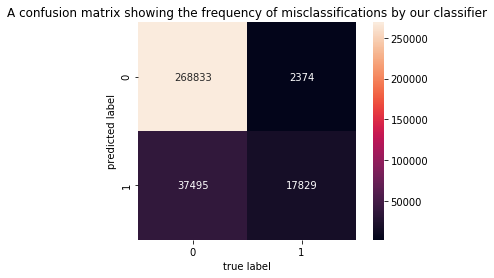

In [48]:
getConfusionMatrix(test_y, pred_test_y)

In [49]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.7015447532917962
0.880045610474979
0.656755869990528


In [50]:
testdf['predicted target'] = pred_test_y
testdf.head()

,question,target,predicted target
0,Which one out of Sony and Gionee provides bett...,0,0
1,Do psychopaths feel emotions under drugs effect?,0,0
2,How do you stay true to your words?,0,0
3,"In forensics, how would a forensic scientist b...",0,0
4,"What does the poem ""A Walk on the Beach"" by Ma...",0,0


## Using GloVe Embeddings

In [51]:
embed_size

100

In [52]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total para

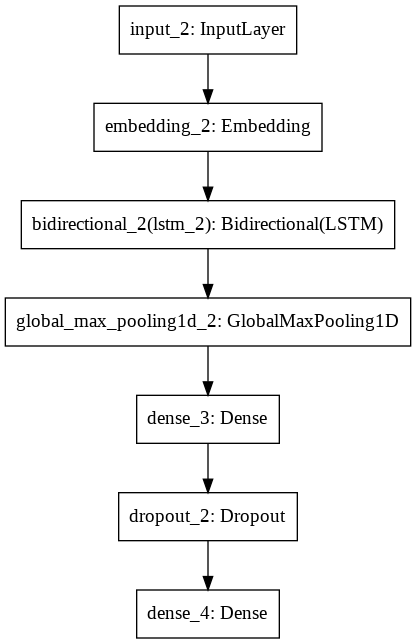

In [53]:
from keras.utils import  plot_model
from IPython.display import Image, display
model_name = 'Using Glove Embeddings'
plot_model(model, to_file = model_name +'-model.png', show_shapes=False)
Image(filename = model_name + '-model.png')

Train on 109092 samples, validate on 97960 samples
Epoch 1/5
109092/109092 [==============================] - 90s 827us/step - loss: 0.3576 - acc: 0.8525 - val_loss: 0.2814 - val_acc: 0.8841
Epoch 2/5
109092/109092 [==============================] - 89s 812us/step - loss: 0.2645 - acc: 0.8983 - val_loss: 0.2563 - val_acc: 0.8943
Epoch 3/5
109092/109092 [==============================] - 92s 839us/step - loss: 0.2320 - acc: 0.9139 - val_loss: 0.2005 - val_acc: 0.9185
Epoch 4/5
109092/109092 [==============================] - 91s 834us/step - loss: 0.2080 - acc: 0.9241 - val_loss: 0.3694 - val_acc: 0.8431
Epoch 5/5
109092/109092 [==============================] - 93s 850us/step - loss: 0.1812 - acc: 0.9359 - val_loss: 0.3167 - val_acc: 0.8739


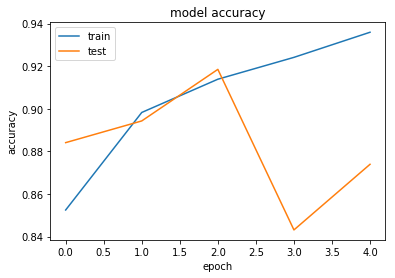

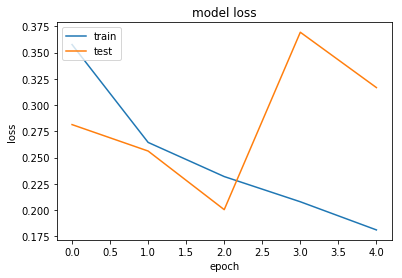

Test Accuracy: 87.535946


In [54]:
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=5, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [55]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)


thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)


97960/97960 [==============================] - 14s 140us/step
F1 score at threshold 0.1 is 0.32414614553613474
F1 score at threshold 0.11 is 0.33190279948841833
F1 score at threshold 0.12 is 0.33827203532624484
F1 score at threshold 0.13 is 0.3442045084273823
F1 score at threshold 0.14 is 0.3501116542941638
F1 score at threshold 0.15 is 0.3552599313388916
F1 score at threshold 0.16 is 0.360150633344745
F1 score at threshold 0.17 is 0.3653426865105697
F1 score at threshold 0.18 is 0.36982921593130186
F1 score at threshold 0.19 is 0.3750040662307667
F1 score at threshold 0.2 is 0.3793228497016451
F1 score at threshold 0.21 is 0.38323153432795964
F1 score at threshold 0.22 is 0.3872274353608317
F1 score at threshold 0.23 is 0.3909019500700113
F1 score at threshold 0.24 is 0.39390386869871047
F1 score at threshold 0.25 is 0.3975462688648007
F1 score at threshold 0.26 is 0.40109890109890106
F1 score at threshold 0.27 is 0.4044528221360743
F1 score at threshold 0.28 is 0.4079916633727407
F1 

In [56]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

326531/326531 [==============================] - 41s 124us/step
[[     0 269165]
 [     1  57366]]


Sensitivity: 91.25%
Specificity: 87.29%


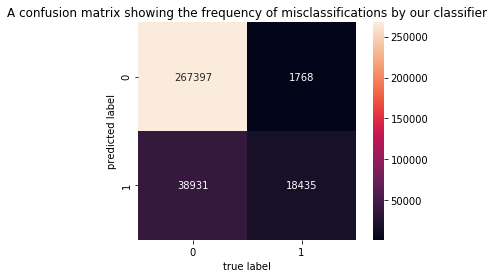

In [57]:
getConfusionMatrix(test_y, pred_test_y)

In [58]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.7022992569090594
0.8926994902622403
0.6573945684266667


In [59]:
testdf['predicted target - GloVe'] = pred_test_y
testdf.head()

,question,target,predicted target,predicted target - GloVe
0,Which one out of Sony and Gionee provides bett...,0,0,0
1,Do psychopaths feel emotions under drugs effect?,0,0,0
2,How do you stay true to your words?,0,0,0
3,"In forensics, how would a forensic scientist b...",0,0,0
4,"What does the poem ""A Walk on the Beach"" by Ma...",0,0,0


## Using Wiki News FastText Embeddings

In [60]:
import os
from os.path import join, exists
from keras.utils.data_utils import get_file

wiki_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip'
wiki_filename = 'wiki-news-300d-1M.vec.zip'
wiki_loc = join(wiki_filename)

if not exists(wiki_loc):
    print('Download %s' % wiki_filename)
    get_file(wiki_filename, wiki_url, cache_dir='.', extract=True)

Download wiki-news-300d-1M.vec.zip


In [61]:
EMBEDDING_FILE = 'datasets/wiki-news-300d-1M.vec'

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE) if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


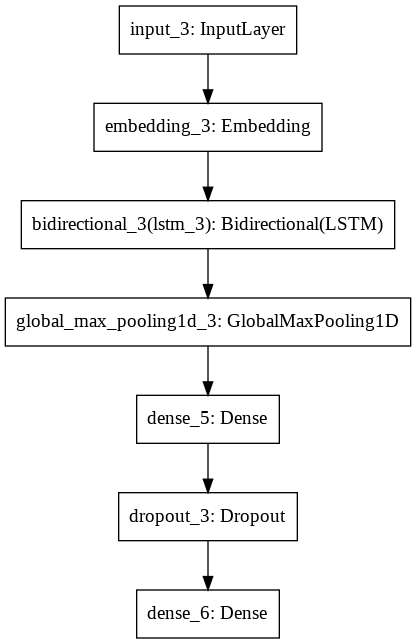

In [63]:
from keras.utils import  plot_model
from IPython.display import Image, display
model_name = 'Using Wiki News FastText Embeddings'
plot_model(model, to_file = model_name +'-model.png', show_shapes=False)
Image(filename = model_name + '-model.png')

Train on 109092 samples, validate on 97960 samples
Epoch 1/5
109092/109092 [==============================] - 97s 889us/step - loss: 0.3295 - acc: 0.8666 - val_loss: 0.2730 - val_acc: 0.8867
Epoch 2/5
109092/109092 [==============================] - 93s 855us/step - loss: 0.2338 - acc: 0.9127 - val_loss: 0.2931 - val_acc: 0.8735
Epoch 3/5
109092/109092 [==============================] - 94s 861us/step - loss: 0.1984 - acc: 0.9280 - val_loss: 0.3075 - val_acc: 0.8724
Epoch 4/5
109092/109092 [==============================] - 92s 845us/step - loss: 0.1640 - acc: 0.9416 - val_loss: 0.3427 - val_acc: 0.8678
Epoch 5/5
109092/109092 [==============================] - 92s 841us/step - loss: 0.1305 - acc: 0.9536 - val_loss: 0.3231 - val_acc: 0.8809


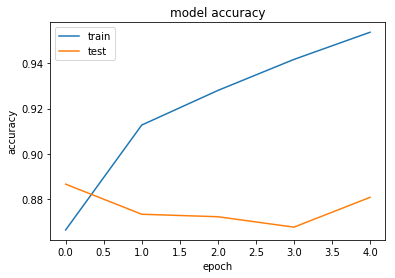

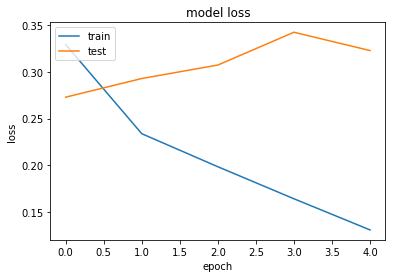

Test Accuracy: 88.270026


In [64]:
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=5, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [65]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)


thresholds = []
for thresh in np.arange(0.1, 0.501, 0.01):
    thresh = np.round(thresh, 2)
    res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
    thresholds.append([thresh, res])
    print("F1 score at threshold {0} is {1}".format(thresh, res))
    
thresholds.sort(key=lambda x: x[1], reverse=True)
best_thresh = thresholds[0][0]
print("Best threshold: ", best_thresh)

97960/97960 [==============================] - 13s 129us/step
F1 score at threshold 0.1 is 0.3580926036525949
F1 score at threshold 0.11 is 0.36415426468234924
F1 score at threshold 0.12 is 0.3694993648415361
F1 score at threshold 0.13 is 0.3743962950711214
F1 score at threshold 0.14 is 0.3796056830013771
F1 score at threshold 0.15 is 0.3839863713798978
F1 score at threshold 0.16 is 0.38777762449993103
F1 score at threshold 0.17 is 0.3915986323354965
F1 score at threshold 0.18 is 0.39604240282685516
F1 score at threshold 0.19 is 0.3993148485172894
F1 score at threshold 0.2 is 0.40233530344529334
F1 score at threshold 0.21 is 0.40613613175921875
F1 score at threshold 0.22 is 0.4096412143514259
F1 score at threshold 0.23 is 0.4128174662111985
F1 score at threshold 0.24 is 0.4156242978054078
F1 score at threshold 0.25 is 0.41798821930222024
F1 score at threshold 0.26 is 0.42056003652412116
F1 score at threshold 0.27 is 0.4233778186838473
F1 score at threshold 0.28 is 0.4260977118119974
F1

In [66]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
pred_test_y = (pred_test_y > best_thresh).astype(int)

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

326531/326531 [==============================] - 41s 125us/step
[[     0 272828]
 [     1  53703]]


In [67]:
pred_test_y

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [68]:
test_y

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
p_y = [i[0] for i in pred_test_y]

Sensitivity: 88.12%
Specificity: 88.28%


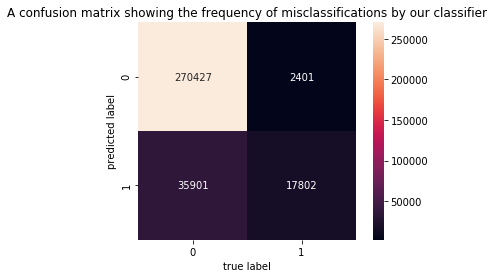

In [70]:

getConfusionMatrix(test_y, p_y)

In [71]:
print(f1_score(pred_test_y, test_y, average="macro"))
print(precision_score(pred_test_y, test_y, average="macro"))
print(recall_score(pred_test_y, test_y, average="macro"))

0.7078064582415211
0.8819791792040774
0.6613447222610376


In [72]:
testdf['predicted target - Wiki'] = pred_test_y
testdf.head()

,question,target,predicted target,predicted target - GloVe,predicted target - Wiki
0,Which one out of Sony and Gionee provides bett...,0,0,0,0
1,Do psychopaths feel emotions under drugs effect?,0,0,0,0
2,How do you stay true to your words?,0,0,0,0
3,"In forensics, how would a forensic scientist b...",0,0,0,0
4,"What does the poem ""A Walk on the Beach"" by Ma...",0,0,0,0


In [0]:
testdf.to_csv("Output.csv", encoding='utf-8', index=False)
